# Flexible synthetic control 
We follow Doudchenko and Imbens (2013) - [arxiv link](https://arxiv.org/abs/1610.07748) - hereafter **DI**. The main motivation is that difference-in-difference (DiD) and synthetic control (SC) methods can be generalized as their constraints around how to estimate weights $\omeega$ that can be used create the counterfactual outcome of the treatment as if it were control, 
$\hat{Y}_{0,T}(0) = \mu + \sum^N_{i=1} \omega_i Y_{i,T}$ , 


where $i=0$ denotes the treated unit; $i=1,...,N$ are control units, and $T$ is a given time period.

|Formula | Condition | Model that use this Condition |
|------|---| ---|
|$\mu=0$| (No-Intercept)| SC |
|$\sum_i^N \omega_i = 1$ | (Adding-Up)| DiD, SC |
|$\omega_i \geq 0$ | (Non-Negativity)| DiD, SC |
|$\omega_i = \bar{\omega_i}$ | (Constant-Weights)| DiD |

The (No-Intercept) and (Adding-Up) assumption works against us if our treated units ($i=0$) is an outlier unit compared to other control units ($i=1,...,N$). Note that DiD won't have this problem because it allows for an intercept difference. 

The (Non-Negativity) assumes can give us additional precision because only a few units can have weights, and allows good interpretability. However, allowing a more uniform distribution of weights and allowing them to be negative can reduce bias, as we can see in some matching scenarios [Abadie and Imbens, 2011](https://economics.mit.edu/files/11861). 

Finally, one of SC's contributions is relaxing the (Constant-Weights) assumption in DiD so have flexible weights.






**DI** proposes a way to estimate $(\mu, \omega)$ that allows us to relax all of the assumptions, using a penalized function. Note that $||...||_l$ is the $l$-th penalty function, where $l=1$ is absolute value and $l=2$ is squared.


$$ (\hat{\mu}(\lambda, \alpha), \hat{\omega}(\lambda, \alpha))  = \text{argmin} \Big\{ || Y_{0,t'} - \mu - \sum_{i=1}^N \omega_i Y_{i, t'} | t' < 0 ||^2_2 + \lambda ( \frac{1-\alpha}{2}||\omega||^2_2 + \alpha||\omega||_1)   \Big\} $$

This would be estimated with an elastic net function. Note that:
1. We don't want to scale the control unit outcomes because since we have an intercept the interpretation won't be correct if we scale.
2. Weights are *only likely* to sum up to one, so we need to be careful about estimates that shrink $\omega$ towards zero. This is exactly what the original SC model deals with.
3. Imposing LASSO won't work because since the weights are likely to sum to one, just an L1-penalty would be useful.

The above two issues are addressed with a particular type of cross-validation. Where regular cross-validation would have us split the treated and control units randomly, we only want to evaluate on control units. 

1. Choose values of $\lambda, \alpha$.
2. Exclude treated unit $i=0$ from the sample.
3. For each control unit $j=1,...,N$:
    1. Pretend unit $j$ is the control unit.
    2. Estimate $\omega, \mu$ using the elastic net $-\rightarrow \omega_j, \mu_j$
    3. Calculate the predicted difference: $Y_j - \mu_j - \omega_j^T Y_{-j} \rightarrow \tilde{Y}_j$
4. Calculate a single statistics over the predicted differences, for example $MSE = \frac{1}{N}\sum_j ( \tilde{Y}_j)^2$

Repeat Steps 1 through 4 for different values of $\lambda, \alpha$. Pick $\lambda, \alpha$ with the best performance of MSE above. Note that $\alpha >0 $ and $0\leq \lambda \leq 1$

Our procedure for coding this up is to have separate functions that do:
1. Clean data to identify $Y_0$ and  $Y_i$ datasets.
2. Given $Y_0$ (or a pretend $Y_j$), $Y_i$, and $\lambda,\alpha$, estimate $\mu, \omega$.
3. Only use $Y_i$ to estimate $\lambda,\alpha$. - This can be done by a grid search, or through an optimizer if we like.

In [1]:
def clean_and_input_data(dataset, treatment, post):
    C_pre = dataset.loc[(dataset[treatment]==0) & (dataset[post]==0)].pivot_table(columns='unitid',
                                            index='T',
                                            values='Y')
    C_pst = dataset.loc[(dataset[treatment]==0) & (dataset[post]==1)].pivot_table(columns='unitid',
                                            index='T',
                                            values='Y')
    T_pre = dataset.loc[(dataset[treatment]==1) & (dataset[post]==0)].pivot_table(columns='unitid',
                                            index='T',
                                            values='Y')
    T_pst = dataset.loc[(dataset[treatment]==1) & (dataset[post]==1)].pivot_table(columns='unitid',
                                            index='T',
                                            values='Y')
    return {'C_pre':C_pre, 'C_pst':C_pst, 'T_pre':T_pre, 'T_pst':T_pst}
class di:
    def estimate_mu_omega(treatment_pre, control_pre, alpha_lambda_0):
        alpha_0, lambda_0 = alpha_lambda_0[0], alpha_lambda_0[1]
        elnet = ElasticNet(random_state=2736, alpha=alpha_0, l1_ratio=lambda_0)
        elnet.fit(control_pre, treatment_pre )
        ## Output interpretable weights
        try:
            df_weights = pd.DataFrame(index=elnet.feature_names_in_, 
                         data=elnet.coef_.T,
                        columns=treatment_pre.columns)
        except:
            df_weights = pd.DataFrame(index=elnet.feature_names_in_, 
                         data=elnet.coef_.T)        
        return {'mu': elnet.intercept_, 'omega': elnet.coef_, 'weights':df_weights, 'full':elnet}

    def predict_mu_omega(treatment_pre, control_pre, alpha_lambda_0, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]]
        treatment_holdout = treatment_pre[0:holdout_windows[0]]    
        
        control_nonholdout = control_pre[holdout_windows[0]:]
        treatment_nonholdout = treatment_pre[holdout_windows[0]:]
        
        ## Estimate the DI model
        holdout_dict = di.estimate_mu_omega(treatment_holdout, control_holdout, alpha_lambda_0)
        ## Estimate measure of fit for the hold out and non-holdout sample
        diff_holdout = treatment_holdout       - np.dot(control_holdout, holdout_dict['omega'].T)+holdout_dict['mu']
        diff_holdout_mse = np.mean(diff_holdout**2)
        diff_nonholdout = treatment_nonholdout - np.dot(control_nonholdout, holdout_dict['omega'].T)+holdout_dict['mu']
        diff_nonholdout_mse = np.mean(diff_nonholdout**2)
        
        return {'mu':     holdout_dict['mu'],
               'omega':   holdout_dict['omega'],
               'weights': holdout_dict['weights'],
               'full':    holdout_dict['full'],
               'mse_holdout': diff_holdout_mse,
               'mse_nonholdout':diff_nonholdout_mse}

    
    def sc_style_results(treatment_pre, treatment_pst, control_pre, control_pst, mu,omega):
        final_X = pd.concat([treatment_pre, treatment_pst], axis=0)
        control_X = pd.concat([di_dict['C_pre'], di_dict['C_pst']], axis=0)

        control_df = mu + pd.DataFrame(data=np.dot(control_X, omega.T), columns=[ l+'_est' for l in final_X.columns ])
        control_df.index = final_X.index
        
        output_df = control_df.join(final_X)
        
        treatment_periods = -1*len(treatment_pst)
        atet_df = pd.DataFrame()
        for c in [l for l in output_df.columns if '_est' not in l]:
            diff = output_df[c][treatment_periods:] - output_df[c+'_est'][treatment_periods:]
            atet_df[c] = diff
        
        return {'atet': atet_df , 'predict_est':output_df}

In [2]:
## Optimizer for that class
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import minimize

## Here code up the functions that we will try to minimize over
class alpha_lambda:
    def diff(y_t,y_c, mu_x, omega_x):
        return y_t - mu_x - np.dot(y_c,omega_x)

    def alpha_lambda_transform(alpha_lambda_raw_):
        ## Alpha is strictly greater than zero
        ## lambda exists between 0 and 1
        return np.exp(alpha_lambda_raw_[0]/1000), np.exp(alpha_lambda_raw_[1])/(1+np.exp(alpha_lambda_raw_[1])), 
    def alpha_lambda_diff(alpha_lambda_raw_, control_pre):
        ## Transform the inputted alpha,lambda values 
        alpha_lambda_t = alpha_lambda.alpha_lambda_transform(alpha_lambda_raw_)
        difference_array = []
        ## Pick one control unit as the pretend treatment unit
        for u in control_pre.columns:
            control_pre_placebo_treat = control_pre[u]
            control_pre_placebo_cntrl = control_pre[ [l for l in control_pre.columns if l !=u] ]

            ## Estimate mu and lambda with that control unit
            control_pre_placebo_w = di.estimate_mu_omega(control_pre_placebo_treat,
                             control_pre_placebo_cntrl,
                             alpha_lambda_t)
            ## Estimate the difference
            d = alpha_lambda.diff(control_pre_placebo_treat, 
                 control_pre_placebo_cntrl, 
                 control_pre_placebo_w['mu'],
                 control_pre_placebo_w['omega'])
            difference_array.append(d)
        ## Estimate the difference across all the control units
        d_mean = np.mean(difference_array)
        return d_mean
    def get_alpha_lambda(control_pre_input):
        ## Initialize at a given point
        weights = minimize(partial(alpha_lambda.alpha_lambda_diff, control_pre=control_pre_input),
                             np.array([10.15,0.5]),
                           method='BFGS',
                          options={'maxiter':5000, 'disp':True})
        return weights


In [3]:
import pandas as pd
import numpy as np
import os as os 

import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import display    

import scipy.stats 
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [4]:
def synth_panel(seed_number = 2123, 
                time_units = 10, 
                x_units = 100, 
                K_dim = 5 ,
               at = 2):
    '''
    seed_number  random_number_set
    time_units   how many time periods?
    x_units      how many units?
    K_dim        how many covariates (assume uniform)
    at           ATET estimate
    '''
    def censor_at_x(x,cr):
        x[x >=   cr]   =    cr
        x[x <=-1*cr] = -1*cr
        return x
    censorvalue = 2

    
    ## Set the seed for random number
    xfun = np.random.RandomState(seed_number)
    
    ## Construct covariates, time-invariant fixed effects, and first period outcome
    ## Half of the time, coefficients are negative, half of the time, coefficients are positive
    X = censor_at_x( xfun.normal(0,2, size= (x_units, K_dim) ), 5  )  
    
    X_coef = [xfun.uniform(low=-1*(p%2==0)+1*(p%2!=0),
                          high=-0.5*(p%2==0)+0.5*(p%2!=0) ) for p in range(K_dim)]
    X_coef_W = [xfun.uniform(low=-1*(p%2==0)+1*(p%2!=0),
                          high=-0.5*(p%2==0)+0.5*(p%2!=0) ) for p in range(K_dim)]
    
    x_list = ['x'+str(k) for k in range(K_dim)]
        
    ## Unit fixed effects
    fe = censor_at_x( xfun.normal(0,2, size=x_units), censorvalue)
    ## Time fixed effects
    te = xfun.normal(0,1.5)
    
    ## First period outcome, where the outcome is not a function of the covariates.
    ## Also use this opportunity to determine treatment status
    output_df = pd.DataFrame(data=X, columns=x_list)
    output_df['Y'] = fe + censor_at_x( xfun.normal(0,0.5, size=x_units), censorvalue)
    output_df['T'] = pd.to_datetime('2020/01/01')
    output_df['unitid'] =  np.arange(x_units).astype(int)
    
    ## Decay parameter
    decay = 0.90
    covariates= [r for r in output_df.columns if 'x' in r ]
    
    ## Create the panel by setting up an AR(1) type function.
    ## Also allow a time fixed effect and put the covariates into the outcome
    ## Also assign treatment when we get the treatment time.
    ## Assign treatment time
    treatment_t = int(time_units*0.75)-1
    
    for t in range(1,time_units):    
        
        prev_date = (pd.to_datetime('2020/01/01')+pd.offsets.DateOffset(months=t-1))
        prev_data = decay*( output_df.loc[(output_df['T']==prev_date)][covariates]     )
        ## perturb it a little with AR(1)
        prev_data += (1-decay)*censor_at_x( xfun.normal(0,2, size=(x_units,K_dim)), censorvalue)
                
        ## Time fixed effect, which is correlated over time
        if t==1:
            te = xfun.normal(0,2)
        else:
            te = decay*te + xfun.normal(0,0.5)
            
        prev_data['Y'] = decay*np.dot(prev_data,X_coef) +\
            fe + te +\
            censor_at_x( xfun.normal(0,2, size=x_units), censorvalue)
        prev_data['Y'] += (1-decay)*fe        
        prev_data['T'] = pd.to_datetime('2020/01/01') + pd.offsets.DateOffset(months=t)
        prev_data['unitid'] = np.arange(x_units).astype(int)
        if (t==treatment_t):
            ## Calculate treatment status
            latent_treatment = np.dot(prev_data[covariates],X_coef_W) 
#                 xfun.normal(0,0.25,size=len(prev_data))
            ## First define treated units based on the latent treatment exceeding some threshold    
            threshold_upper = np.percentile( latent_treatment, q=90)    
            treated_ids = list( prev_data.loc[(latent_treatment>= threshold_upper) ]['unitid'].unique() )

        else:
            pass
        output_df = pd.concat([ output_df, prev_data])
        
    output_df['treatment'] = (output_df['unitid'].isin(treated_ids) )*1
    output_df['Y_control'] = output_df['Y'].values
    
    ## Assign treatment values at treatment times
    ## Let treatment value depend on the covariates over time. Use a different
    ## set of parameters to aggregate the covariates so treatment status is not
    ## as tightly correlated with the control outcome.
    ## Let treatment all happen at the same time.
    treatment_time = (output_df['T'] >= pd.to_datetime('2020/01/01')+\
                      pd.offsets.DateOffset(months=treatment_t ) )        

    ## Treatment unit assignment
    ## Treatment ATET ground truth for treated units
    output_df['treatment_GT'] = (treatment_time & (output_df['treatment']==1) )*at

    ## Treatment interaction post 
    output_df['post'] = (treatment_time )*1
    
    ## Treatment interaction post and unit
    output_df['treatmentxpost'] = (treatment_time &  (output_df['treatment']==1) )*1
    
    ## Apply treatment to outcome
    output_df['Y'] += (treatment_time &  (output_df['treatment']==1)  )*at


    output_df['unitid'] = 'unit' + output_df['unitid'].apply(str)
    return output_df

Covariate Balance Plot


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
treatment,,,,,,,,,,,,,,,,,,,,
0,0.031385,-0.017263,0.272104,-0.083781,0.187213,0.042136,0.131786,-0.341387,0.241360,-0.195068,-0.185287,0.026644,-0.163751,-0.167769,-0.051402,-0.244845,0.302492,-0.032590,0.047574,0.062227
1,-0.592918,-0.318402,0.106922,-0.214898,-0.155678,-0.155354,-0.514416,0.165507,0.283671,0.213168,-0.392272,0.078895,-0.525142,0.348136,-0.184184,0.640309,0.138342,0.320989,-0.482449,0.487414


Plot stuff


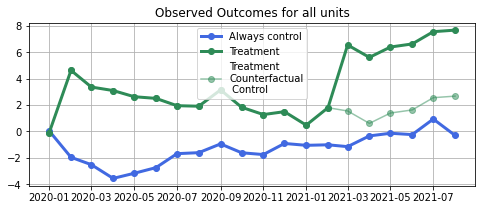

In [5]:
treatment_list = {'units': [np.arange(0,5,1)],
                             'time': [15],
                             'atet':[4] }
at_gt = 5
df = synth_panel(seed_number = 2752, 
                time_units = 20, 
                x_units = 50, 
                K_dim = 20,
                at = at_gt )

# display( df[[r for r in df.columns if 'treatment' in r and 'GT' not in r]].describe() )
# display('Test for overlap in treatment')
# display(pd.crosstab(df['treatment'], df['treatmentxpost']))

print('Covariate Balance Plot')
x_list = [p for p in df.columns if p[0]=='x']
display(  df.groupby('treatment')[x_list].mean()  )

print('Plot stuff')
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

ax.plot(df.loc[(df['treatment']==0)].groupby('T')['Y'].mean() , 
           '-o', color='royalblue', 
        linewidth=3, label='Always control')
ax.plot(df.loc[(df['treatment']==1) ].groupby('T')['Y'].mean() , 
           '-o', color='seagreen', 
        linewidth=3, label='Treatment')

ax.plot(df.loc[(df['treatment']==1) ].groupby('T')['Y_control'].mean() , 
           '-o', color='seagreen', alpha=0.50,
        label='Treatment\nCounterfactual\n Control')

ax.set_title('Observed Outcomes for all units')
ax.grid()
ax.legend()



Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1


/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


              unit11    unit24    unit31    unit34    unit49
T                                                           
2021-03-01  4.339097  4.073200  7.810119  6.509017  2.808490
2021-04-01  5.249407  5.468315  5.806464  2.769946  2.946630
2021-05-01  7.591982  6.569072  5.091909  5.188028  3.570815
2021-06-01  5.881162  5.732402  3.797319  5.488496  4.856359
2021-07-01  6.097481  9.767800  5.462754  3.676359  5.646345
2021-08-01  6.728569  7.148621  5.705412  7.169132  7.576806


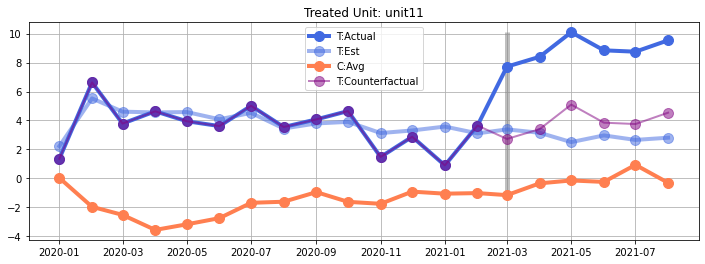

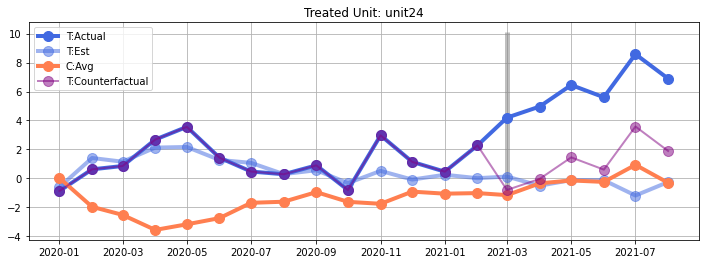

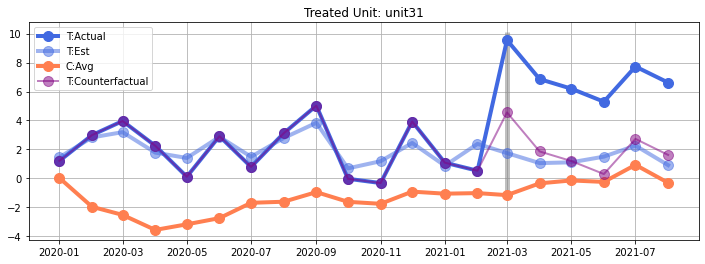

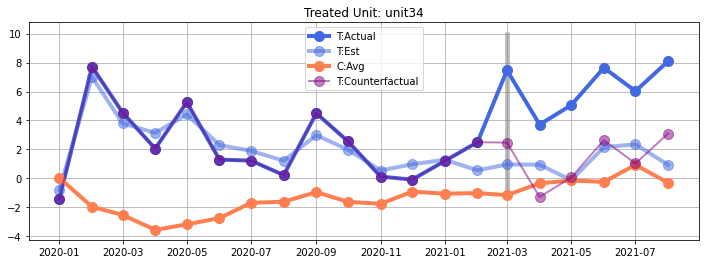

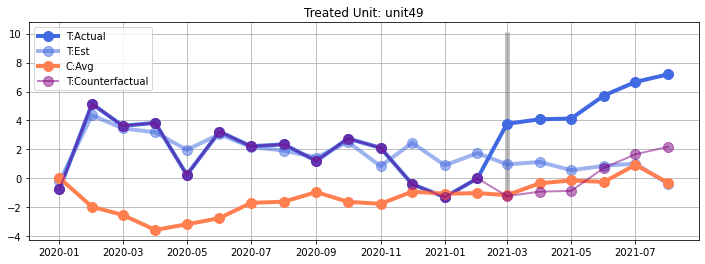

In [6]:
## Clean data
di_dict = clean_and_input_data(df, 'treatment', 'post')
## Figure out the alpha and lambda values
w=alpha_lambda.get_alpha_lambda(di_dict['C_pre'])
alpha_lambda_to_use = alpha_lambda.alpha_lambda_transform(w.x)
## Take the alpha and lambda values, and estimate mu and omega
di_est = di.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use, [10,4])
# di_est = di.estimate_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use)
di_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                    di_dict['C_pre'], di_dict['C_pst'],
                        di_est['mu'],di_est['omega'])
# display(di_output['predict_est'])
print(di_output['atet'])


for r in [j for j in di_output['predict_est'].columns if '_est' not in j]:
    fig,ax=plt.subplots(ncols=1,nrows=1, figsize=(12,4))
    ax.plot(di_output['predict_est'].index, di_output['predict_est'][r], '-o', label='T:Actual', 
           color='royalblue', alpha=1.0, linewidth=4, ms=10)
    ax.plot(di_output['predict_est'].index, di_output['predict_est'][r+'_est'], '-o', label='T:Est',
           color='royalblue', alpha=0.5, linewidth=4, ms=10)
    ax.plot(di_output['predict_est'].index, pd.concat([di_dict['C_pre'],di_dict['C_pst']],axis=0).mean(axis=1),
           '-o',label='C:Avg',
           color='coral', linewidth=4, ms=10)
    ax.plot(di_output['predict_est'].index, df.loc[df['unitid']==r]['Y_control'],
            '-o',label='T:Counterfactual',
           color='purple', alpha=0.5, linewidth=2, ms=10)            
    ax.vlines(df.loc[(df['post']==1)]['T'].min(), 
              di_output['predict_est'].min().min(),
              di_output['predict_est'].max().max(),              
              linewidth=5, color='grey',alpha=0.5)
    ax.grid()
    ax.set_title('Treated Unit: {0}'.format(r))
    ax.legend()
    plt.show()